####Author: William C Francis (willcf)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


###(a)

####Reading in dataset and taking first two classes

In [ ]:
# Reading in the dataset

trainset = torchvision.datasets.MNIST(root='./data', train = True, download = True, transform = transforms.ToTensor())
idx = (trainset.targets==0) | (trainset.targets==1) # Taking the first two classes
trainset.targets = trainset.targets[idx]
trainset.data = trainset.data[idx]

testset = torchvision.datasets.MNIST(root='./data', train = False, download = True, transform = transforms.ToTensor())
idx = (testset.targets==0) | (testset.targets==1)
testset.targets = testset.targets[idx]
testset.data = testset.data[idx]

####Subsampling images and changing labels to 1 and -1

In [ ]:
xtrain = trainset.data.numpy()
y_train = trainset.targets.numpy()
xval = testset.data.numpy()
y_val = testset.targets.numpy()

r,_,_ = xtrain.shape
x_train = np.zeros([r,14*14])
for i in range(r):
  a = cv2.resize(xtrain[i], (14,14)) # Resizing the image from 28*28 to 14*14
  b = a.flatten()
  x_train[i] = b
  if(y_train[i] == 0): # Changing labels from 0 to 1
    y_train[i] = 1
  else:
    y_train[i] = -1  # Changing labels from 1 to -1

r,_,_ = xval.shape
x_val = np.zeros([r,14*14])
for i in range(r):
  a = cv2.resize(xval[i], (14,14)) 
  b = a.flatten()
  x_val[i] = b
  if(y_val[i] == 0):
    y_val[i] = 1
  else:
    y_val[i] = -1
x_train = x_train/255
x_val = x_val/255
y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(12665, 196) (12665,) (2115, 196) (2115, 1)


###(b)

####Logistic Regression using Gradient Descent

In [ ]:
class Logistic_Regression_GD():
  def __init__(self, learning_rate, epochs):		
    self.learning_rate = learning_rate		#Initializing learning rate and number of epochs
    self.epochs = epochs

  def train(self, x, y, x_val, y_val, lmbda, momentum, nesterov):		
    self.m, self.n = x.shape		
    np.random.seed(30)
    self.w = np.random.randn(self.n, 1)	
    self.b = np.random.randn(1,1)
    self.vw = np.zeros_like(self.w)
    self.vb = np.zeros_like(self.b)
    self.x = x
    self.y = y.reshape(-1,1)
    self.lmbda = lmbda
    self.momentum = momentum
    correct=0
    n=0
    train_l = []
    val_l = []
    n_wu = []
    for i in range(self.epochs):	
      if(nesterov == False):
        self.w_update()
      else:
        self.w_update_nesterov()
      n+=1
      n_wu.append(n)
      loss_train = model.loss(self.x, self.y)
      loss_val = model.loss(x_val, y_val)	
      train_l.append(loss_train)
      val_l.append(loss_val)
      if((i+1)%20==0):
        print("(Epoch", i+1, ")  Train Loss: ", round(loss_train,4), "| Val Loss: ", round(loss_val,4))
    y_pred = self.predict(x_val)

    for i in range(np.size(y_pred)):  
      if y_val[i] == y_pred[i]:            
        correct += 1

    print("Accuracy: ", (correct/y_pred.shape[0])*100)
    y2, y1, x2, x1 = np.log(train_l[20]), np.log(train_l[5]), n_wu[20], n_wu[5]
    slope = (y2-y1)/(x2-x1)
    return slope, n_wu, train_l, val_l

  def w_update(self):		
    A = 1 / (1 + np.exp(self.y*((self.x @ self.w) + self.b)))
    dw = np.mean((-self.y * self.x) * A, axis=0) + self.lmbda*np.sum(self.w)
    db = np.mean((-self.y*A),axis=0) + self.lmbda*self.b
    self.w = self.w - self.learning_rate * dw.reshape(-1,1)
    self.b = self.b - self.learning_rate * db
    return self

  def w_update_nesterov(self):	
    new_w = self.w + self.learning_rate*self.momentum*self.vw
    new_b = self.b + self.learning_rate*self.momentum*self.vb
    A = 1 / (1 + np.exp(self.y*(self.x @ new_w + new_b)))
    dw = np.mean((-self.y * self.x) * A, axis=0) + self.lmbda*np.sum(new_w)
    db = np.mean((-self.y*A),axis=0) + self.lmbda*new_b
    self.vw = self.momentum * self.vw - dw.reshape(-1,1)
    self.vb = self.momentum * self.vb - db

    self.w += self.learning_rate * self.vw
    self.b += self.learning_rate * self.vb
    return self

  def loss(self, x, y):	
    z = np.mean(np.log(1+ np.exp(-y*(x @ self.w + self.b)))) + (self.lmbda/2)*((np.linalg.norm(self.w))+np.square(self.b))
    return z.reshape(-1)[0]

  def predict(self, x):
    y = 1 / (1+ np.exp(-x @ self.w - self.b))
    y_pred = np.where(y>0.5, 1, -1)
    return y_pred

####Training Logistic regression GD without Nesterov Momentum

(Epoch 20 )  Train Loss:  1.4911 | Val Loss:  1.5269
(Epoch 40 )  Train Loss:  1.2584 | Val Loss:  1.2837
(Epoch 60 )  Train Loss:  1.0964 | Val Loss:  1.1136
(Epoch 80 )  Train Loss:  0.9757 | Val Loss:  0.9868
(Epoch 100 )  Train Loss:  0.8805 | Val Loss:  0.8872
(Epoch 120 )  Train Loss:  0.8025 | Val Loss:  0.8059
(Epoch 140 )  Train Loss:  0.7371 | Val Loss:  0.7379
(Epoch 160 )  Train Loss:  0.6814 | Val Loss:  0.6801
(Epoch 180 )  Train Loss:  0.6334 | Val Loss:  0.6304
(Epoch 200 )  Train Loss:  0.5917 | Val Loss:  0.5873
(Epoch 220 )  Train Loss:  0.5552 | Val Loss:  0.5496
(Epoch 240 )  Train Loss:  0.523 | Val Loss:  0.5165
(Epoch 260 )  Train Loss:  0.4946 | Val Loss:  0.4873
(Epoch 280 )  Train Loss:  0.4693 | Val Loss:  0.4612
(Epoch 300 )  Train Loss:  0.4467 | Val Loss:  0.438
(Epoch 320 )  Train Loss:  0.4264 | Val Loss:  0.4172
(Epoch 340 )  Train Loss:  0.4081 | Val Loss:  0.3984
(Epoch 360 )  Train Loss:  0.3915 | Val Loss:  0.3815
(Epoch 380 )  Train Loss:  0.3765 

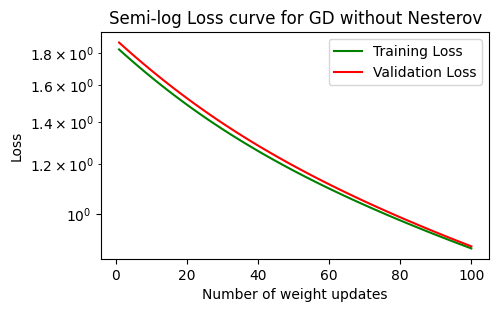

In [ ]:
model = Logistic_Regression_GD(learning_rate = 0.01, epochs = 500)
slope, n_wu_GD, train_l_GD, val_l_GD = model.train(x_train, y_train, x_val, y_val, lmbda=0.01, momentum = 0, nesterov = False)

plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu_GD[:100], train_l_GD[:100], 'g', label='Training Loss') #Plotting the steepest part of the descent
plt.plot(n_wu_GD[:100], val_l_GD[:100], 'r', label='Validation Loss')
plt.yscale('log')
plt.title('Semi-log Loss curve for GD without Nesterov')
plt.xlabel('Number of weight updates')
plt.ylabel('Loss')
plt.legend()

In [ ]:
print("The slope of the line is: ", round(slope,4))
kappa = -1/(slope)
print("The value of kappa, k = ", kappa)
momentum = (np.sqrt(kappa)-1)/(np.sqrt(kappa)+1) #Finding momentum parameter
print("For Nesterov momentum, the momentum coefficient can be set to",round(momentum,4))

The slope of the line is:  -0.0102
The value of kappa, k =  97.59442910006985
For Nesterov momentum, the momentum coefficient can be set to 0.8162


###(c)

####Training Logistic Regression GD with Nesterov Momentum

(Epoch 20 )  Train Loss:  0.9087 | Val Loss:  0.9153
(Epoch 40 )  Train Loss:  0.5773 | Val Loss:  0.5722
(Epoch 60 )  Train Loss:  0.4226 | Val Loss:  0.4131
(Epoch 80 )  Train Loss:  0.3395 | Val Loss:  0.328
(Epoch 100 )  Train Loss:  0.289 | Val Loss:  0.2766
(Epoch 120 )  Train Loss:  0.2553 | Val Loss:  0.2426
(Epoch 140 )  Train Loss:  0.2315 | Val Loss:  0.2185
(Epoch 160 )  Train Loss:  0.2136 | Val Loss:  0.2006
(Epoch 180 )  Train Loss:  0.1998 | Val Loss:  0.1868
(Epoch 200 )  Train Loss:  0.1887 | Val Loss:  0.1759
(Epoch 220 )  Train Loss:  0.1797 | Val Loss:  0.167
(Epoch 240 )  Train Loss:  0.1722 | Val Loss:  0.1596
(Epoch 260 )  Train Loss:  0.1658 | Val Loss:  0.1533
(Epoch 280 )  Train Loss:  0.1603 | Val Loss:  0.148
(Epoch 300 )  Train Loss:  0.1555 | Val Loss:  0.1434
(Epoch 320 )  Train Loss:  0.1513 | Val Loss:  0.1393
(Epoch 340 )  Train Loss:  0.1476 | Val Loss:  0.1357
(Epoch 360 )  Train Loss:  0.1442 | Val Loss:  0.1326
(Epoch 380 )  Train Loss:  0.1412 | 

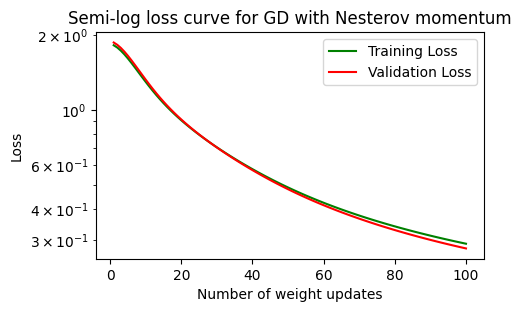

In [ ]:
model = Logistic_Regression_GD(learning_rate = 0.01, epochs = 500)
slope, n_wu_GDnst, train_l_GDnst, val_l_GDnst = model.train(x_train, y_train, x_val, y_val, lmbda=0.01, momentum = momentum, nesterov = True)

plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu_GDnst[:100], train_l_GDnst[:100], 'g', label='Training Loss') #Plotting the steepest part of the descent
plt.plot(n_wu_GDnst[:100], val_l_GDnst[:100], 'r', label='Validation Loss')
plt.yscale('log')
plt.title('Semi-log loss curve for GD with Nesterov momentum')
plt.xlabel('Number of weight updates')
plt.ylabel('Loss')
plt.legend()

In [ ]:
print("The slope of the line is: ", round(slope,4))
kappa_nesterov = 1/(slope**2)
print("The value of kappa, k = ", kappa_nesterov)

The slope of the line is:  -0.0374
The value of kappa, k =  716.6470013144542


####Logistic Regression using Stochaistic Gradient Descent

In [ ]:
class Logistic_Regression_SGD():
  def __init__(self, learning_rate, epochs):		
    self.learning_rate = learning_rate		#Initializing learning rate and number of epochs
    self.epochs = epochs

  def train(self, x, y, x_val, y_val, lmbda, momentum, batch_size, nesterov):		
    self.m, self.n = x.shape		
    np.random.seed(30)
    self.w = np.random.randn(self.n, 1)	
    self.b = np.random.randn(1,1)
    self.vw = np.zeros_like(self.w)
    self.vb = np.zeros_like(self.b)
    self.lmbda = lmbda
    self.momentum = momentum
    correct=0
    n=0
    train_l = []
    val_l = []
    n_wu = []
    for i in range(self.epochs):
      for batch in range(x.shape[0]//batch_size):
        indexes = np.random.randint(0, len(x), batch_size)
        self.x = x[indexes]
        self.y = y[indexes].reshape(-1,1)
        if(nesterov == False):
          self.w_update()
        else:
          self.w_update_nesterov()
        n+=1
        n_wu.append(n)
        loss_train = model.loss(self.x, self.y)
        train_l.append(loss_train)
        indexes = np.random.randint(0, len(x_val), batch_size)
        x_val_batch = x_val[indexes] 
        y_val_batch = y_val[indexes]
        loss_val = model.loss(x_val_batch, y_val_batch)	
        val_l.append(loss_val)

      if((i+1)%20==0):
        print("(Epoch", i+1, ")  Train Loss: ", round(loss_train,4), "| Val Loss: ", round(loss_val,4))

    y_pred = self.predict(x_val)
    for i in range(np.size(y_pred)):  
      if y_val[i] == y_pred[i]:            
        correct += 1

    print("Accuracy: ", (correct/y_pred.shape[0])*100)
    y2, y1, x2, x1 = np.log(train_l[20]), np.log(train_l[5]), n_wu[20], n_wu[5]
    slope = (y2-y1)/(x2-x1)
    return slope, n_wu, train_l, val_l

  def w_update(self):		
    A = 1 / (1 + np.exp(self.y*((self.x @ self.w) + self.b)))
    dw = np.mean((-self.y * self.x) * A, axis=0) + self.lmbda*np.sum(self.w)
    db = np.mean((-self.y*A),axis=0) + self.lmbda*self.b
    self.w = self.w - self.learning_rate * dw.reshape(-1,1)
    self.b = self.b - self.learning_rate * db
    return self

  def w_update_nesterov(self):	
    new_w = self.w + self.learning_rate*self.momentum*self.vw
    new_b = self.b + self.learning_rate*self.momentum*self.vb
    A = 1 / (1 + np.exp(self.y*(self.x @ new_w + new_b)))
    dw = np.mean((-self.y * self.x) * A, axis=0) + self.lmbda*np.sum(new_w)
    db = np.mean((-self.y*A),axis=0) + self.lmbda*new_b
    self.vw = self.momentum * self.vw - dw.reshape(-1,1)
    self.vb = self.momentum * self.vb - db

    self.w += self.learning_rate * self.vw
    self.b += self.learning_rate * self.vb
    return self

  def loss(self, x, y):	
    z = np.mean(np.log(1+ np.exp(-y*(x @ self.w + self.b)))) + (self.lmbda/2)*((np.linalg.norm(self.w))+np.square(self.b))
    return z.reshape(-1)[0]

  def predict(self, x):
    y = 1 / (1+ np.exp(-x @ self.w - self.b))
    y_pred = np.where(y>0.5, 1, -1)
    return y_pred

####Training Logistic regression SGD without Nesterov Momentum

(Epoch 20 )  Train Loss:  0.1645 | Val Loss:  0.1348
(Epoch 40 )  Train Loss:  0.1119 | Val Loss:  0.099
(Epoch 60 )  Train Loss:  0.107 | Val Loss:  0.0962
(Epoch 80 )  Train Loss:  0.0803 | Val Loss:  0.089
(Epoch 100 )  Train Loss:  0.0884 | Val Loss:  0.079
(Epoch 120 )  Train Loss:  0.0808 | Val Loss:  0.0815
(Epoch 140 )  Train Loss:  0.0811 | Val Loss:  0.0945
(Epoch 160 )  Train Loss:  0.0794 | Val Loss:  0.0821
(Epoch 180 )  Train Loss:  0.0785 | Val Loss:  0.0766
(Epoch 200 )  Train Loss:  0.0827 | Val Loss:  0.0941
(Epoch 220 )  Train Loss:  0.1257 | Val Loss:  0.077
(Epoch 240 )  Train Loss:  0.1059 | Val Loss:  0.0815
(Epoch 260 )  Train Loss:  0.0791 | Val Loss:  0.0768
(Epoch 280 )  Train Loss:  0.0811 | Val Loss:  0.0765
(Epoch 300 )  Train Loss:  0.0792 | Val Loss:  0.0796
(Epoch 320 )  Train Loss:  0.0784 | Val Loss:  0.0771
(Epoch 340 )  Train Loss:  0.0824 | Val Loss:  0.0771
(Epoch 360 )  Train Loss:  0.0841 | Val Loss:  0.0777
(Epoch 380 )  Train Loss:  0.0779 | V

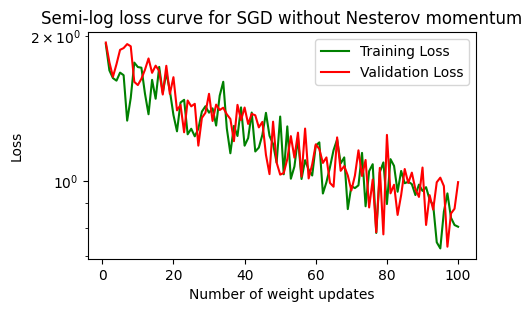

In [ ]:
model = Logistic_Regression_SGD(learning_rate = 0.01, epochs = 500)
slope, n_wu_SGD, train_l_SGD, val_l_SGD = model.train(x_train, y_train, x_val, y_val, lmbda=0.01, momentum = 0, batch_size=128, nesterov = False)

plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu_SGD[:100], train_l_SGD[:100], 'g', label='Training Loss') #Plotting the steepest part of the descent
plt.yscale('log')
plt.plot(n_wu_SGD[:100], val_l_SGD[:100], 'r', label='Validation Loss')
plt.yscale('log')
plt.title('Semi-log loss curve for SGD without Nesterov momentum')
plt.xlabel('Number of weight updates')
plt.ylabel('Loss')
plt.legend()


####Training Logistic regression SGD with Nesterov Momentum

(Epoch 20 )  Train Loss:  0.0925 | Val Loss:  0.0856
(Epoch 40 )  Train Loss:  0.0811 | Val Loss:  0.0787
(Epoch 60 )  Train Loss:  0.0863 | Val Loss:  0.0783
(Epoch 80 )  Train Loss:  0.0757 | Val Loss:  0.0779
(Epoch 100 )  Train Loss:  0.0776 | Val Loss:  0.0757
(Epoch 120 )  Train Loss:  0.0766 | Val Loss:  0.0767
(Epoch 140 )  Train Loss:  0.0763 | Val Loss:  0.0829
(Epoch 160 )  Train Loss:  0.0771 | Val Loss:  0.0782
(Epoch 180 )  Train Loss:  0.0765 | Val Loss:  0.0759
(Epoch 200 )  Train Loss:  0.0786 | Val Loss:  0.0816
(Epoch 220 )  Train Loss:  0.1155 | Val Loss:  0.0763
(Epoch 240 )  Train Loss:  0.094 | Val Loss:  0.077
(Epoch 260 )  Train Loss:  0.0775 | Val Loss:  0.0762
(Epoch 280 )  Train Loss:  0.0775 | Val Loss:  0.0764
(Epoch 300 )  Train Loss:  0.0769 | Val Loss:  0.0802
(Epoch 320 )  Train Loss:  0.0774 | Val Loss:  0.0768
(Epoch 340 )  Train Loss:  0.0784 | Val Loss:  0.0768
(Epoch 360 )  Train Loss:  0.0791 | Val Loss:  0.077
(Epoch 380 )  Train Loss:  0.0779 |

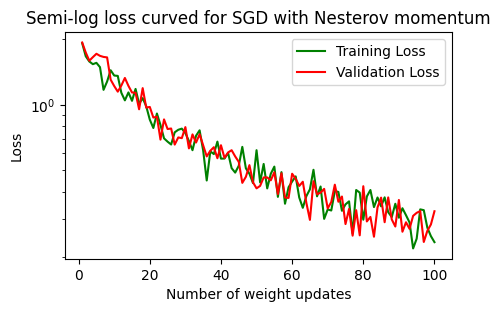

In [ ]:
model = Logistic_Regression_SGD(learning_rate = 0.01, epochs = 500)
slope, n_wu_SGDnst, train_l_SGDnst, val_l_SGDnst = model.train(x_train, y_train, x_val, y_val, lmbda=0.01, momentum = momentum, batch_size=128, nesterov = True)

plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu_SGDnst[:100], train_l_SGDnst[:100], 'g', label='Training Loss') #Plotting the steepest part of the descent
plt.yscale('log')
plt.plot(n_wu_SGDnst[:100], val_l_SGDnst[:100], 'r', label='Validation Loss')
plt.yscale('log')
plt.title('Semi-log loss curved for SGD with Nesterov momentum')
plt.xlabel('Number of weight updates')
plt.ylabel('Loss')
plt.legend()

In [ ]:
print("The slope of the line is: ", round(slope,4))
kappa_nesterov = 1/(slope**2)
print("The value of kappa, k = ", kappa_nesterov)

The slope of the line is:  -0.0429
The value of kappa, k =  542.8170490537813


####Comparing the Loss curves of GD with Nesterov, SGD with Netsreov and SGD without Nesterov

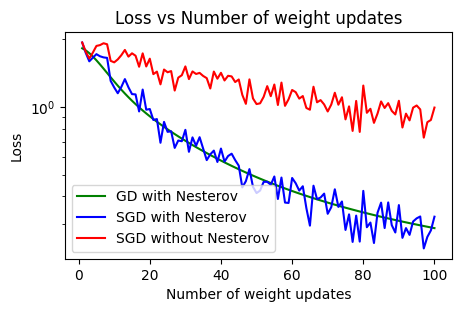

In [ ]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu_GDnst[:100], train_l_GDnst[:100], 'g', label='GD with Nesterov') #Plotting the steepest part of the descent
plt.plot(n_wu_SGDnst[:100], val_l_SGDnst[:100], 'b', label='SGD with Nesterov')
plt.plot(n_wu_SGD[:100], val_l_SGD[:100], 'r', label='SGD without Nesterov')
plt.yscale('log')
plt.title('Loss vs Number of weight updates')
plt.xlabel('Number of weight updates')
plt.ylabel('Loss')
plt.legend()